In [250]:
import numpy as np
import pandas as pd

h1 = pd.read_csv("H1.csv")
h1["HotelType"] = "Resort"
h2 = pd.read_csv("H2.csv")
h2["HotelType"] = "City"
booking = pd.concat([h1, h2], ignore_index=True)
booking.describe()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,391.000000,5400.000000,8.000000,5.000000


In [251]:
# Trimming the ending space at the end of string values
for col in booking.select_dtypes(include='object'):
    booking[col] = booking[col].str.strip()
    
# Drop row with missing country
booking.dropna(subset=['Country'], inplace=True)
    
# Fill missing values
booking['Children'].fillna(0, inplace=True)
cols = ['Company', 'Agent']
for col in cols:
    booking[col] = booking[col].replace('NULL', 0)

# Replace type
booking['Children'] = booking['Children'].astype(np.int64)
booking['Company'] = booking['Company'].astype(np.int64)
booking['Agent'] = booking['Agent'].astype(np.int64)

# Replace inconsitent data 
booking["Meal"].replace(["Undefined"], "SC", inplace=True)

booking.loc[booking["ADR"] < 0, "ADR"] = 0
booking.loc[(booking["IsRepeatedGuest"] == 0) & (booking["PreviousBookingsNotCanceled"] + booking["PreviousCancellations"] > 0), "IsRepeatedGuest"] = 1

# Delete records with 0 guests
booking = booking[(booking['Adults'] + booking['Children'] + booking['Babies']) > 0]

# Delete records with 0 night stay
booking = booking[booking["StaysInWeekendNights"] + booking["StaysInWeekNights"] > 0]

## Feature Engineering

Ta sẽ xử lý các cột không phải là số.

1. Loại bỏ giá trị lớn nhất của cột **LeadTime** vì là outlier

In [253]:
booking = booking[booking.LeadTime < 700]
booking = booking.reset_index(drop=True)

2. Cột **Country** có quá nhiều unique value, ta sẽ map cột country với xác suất người thuộc đất nước đó huỷ booking, đồng thời bỏ các dòng giá trị nan

In [320]:
def map_country_column(booking, label):
    vc_all = booking.loc[:, 42].value_counts()
    vc_pos = booking[label==1].loc[:, 42].value_counts()

    country_map = {}

    for key in vc_all.keys():
        count_pos = vc_pos.get(key, default=0)
        country_map[key] = count_pos / vc_all.get(key)

    booking.loc[:, 42] = booking.loc[:, 42].map(country_map)
    return booking

from sklearn.base import BaseEstimator, TransformerMixin

class MapCountryColumn(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        self.country_map = {}
        
    def fit(self, X, y):
        vc_all = X.loc[:, 42].value_counts()
        vc_pos = X[y==1].loc[:, 42].value_counts()

        for key in vc_all.keys():
            count_pos = vc_pos.get(key, default=0)
            self.country_map[key] = count_pos / vc_all.get(key)
#         for c, a in self.country_map:
#             print(c, a)
        return self
    
    def transform(self, X, y=None):
        copy = X.copy()
        copy.loc[:, 42] = copy.loc[:, 42].map(self.country_map)
        return copy

In [275]:
after = MapCountryColumn().fit_transform(X_train.copy(), y_train)
after.loc[:, 42].value_counts()
# X_train[y_train.IsCanceled==1].loc[:, 42].value_counts()

0.573253    33507
0.201150     8521
0.185677     7233
0.252745     6010
0.169086     5098
            ...  
0.181818       11
0.750000        8
0.875000        8
0.857143        7
0.600000        5
Name: 42, Length: 89, dtype: int64

3. **ReservationStatus** và **ReservationStatusDate** chứa thông tin sau khi khách trả phòng, ta bỏ 2 cột này. Bỏ cột **ArrivalDateYear**, các cột **ArrivalDateMonth**, **ArrivalDateWeekNumber**, **ArrivalDateDayOfMonth** cũng có thể bỏ nếu  chỉ tăng hiệu năng model lên không đáng kể.

In [255]:
cols = ['ArrivalDateYear', 'ArrivalDateMonth', 'ArrivalDateDayOfMonth', \
        'ArrivalDateWeekNumber', 'ReservationStatus', 'ReservationStatusDate']

booking = booking.drop(cols, axis=1)

4. Đổi giá trị trong một số cột từ số thành boolean ("có" hay "không")

In [256]:
from sklearn.base import BaseEstimator, TransformerMixin

class ToBooleanColumn(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self # nothing else to do 
    def transform(self, df, y=None):
        return df.apply(lambda x : x.apply(lambda x : min(1, x)))

5. Tạo cột **IsDesiredRoomType**

In [257]:
d = {'col1': [1, 2], 'col2': [3, 4]}
df = pd.DataFrame(data=d)
df = df.apply(lambda x : x.apply(lambda x : min(1, x)))
df

,col1,col2
0,1,1
1,1,1


In [258]:
from sklearn.base import BaseEstimator, TransformerMixin

class CreateIsDesiredRoomTypeColumn(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self # nothing else to do 
    def transform(self, booking, y=None):
        booking['IsDesiredRoomType'] = booking.ReservedRoomType == booking.AssignedRoomType
        booking.IsDesiredRoomType = booking.IsDesiredRoomType.astype(int)
        return booking.drop(['ReservedRoomType', 'AssignedRoomType'], axis=1)

6. One-hot encode các categorical features

In [259]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['MarketSegment', 'CustomerType', 'DistributionChannel', 'DepositType', \
        'Meal', 'HotelType']
num_cols = ['LeadTime', 'StaysInWeekendNights', 'StaysInWeekNights', 'Adults', 'Children', 'Babies', \
           'Agent', 'ADR']
room_type_cols = ['ReservedRoomType', 'AssignedRoomType']
to_bool_cols = ['DaysInWaitingList', 'RequiredCarParkingSpaces', 'TotalOfSpecialRequests', \
    'PreviousCancellations', 'PreviousBookingsNotCanceled', 'Company', 'BookingChanges']
preserved_cols = ['Country']

class PreserveColumn(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self # nothing else to do 
    def transform(self, booking, y=None):
        return booking


num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
     ("num", num_pipeline, num_cols),
     ("cat", OneHotEncoder(), cat_cols),
     ("roomtype", CreateIsDesiredRoomTypeColumn(), room_type_cols),
     ("bool", ToBooleanColumn(), to_bool_cols),
     ("preserve", PreserveColumn(), preserved_cols),
 ])
booking_prepared = full_pipeline.fit_transform(booking)

In [260]:
booking_prepared

array([[-0.914421749882178, -0.9400095192800347, -0.8035660572875851,
        ..., 0, 0, 'GBR'],
       [-0.8583154606793161, -0.9400095192800347, -0.8035660572875851,
        ..., 0, 0, 'GBR'],
       [-0.8489644124788391, -0.9400095192800347, -0.2729195706208725,
        ..., 0, 0, 'GBR'],
       ...,
       [-0.6619434484692995, 1.074429404988842, 1.3190198893792655, ...,
        0, 0, 'DEU'],
       [0.03938516656647361, 1.074429404988842, 1.3190198893792655, ...,
        0, 0, 'GBR'],
       [0.9370857938122633, 1.074429404988842, 2.3803128627126906, ...,
        0, 0, 'DEU']], dtype=object)

## Modeling

In [400]:
from sklearn.model_selection import StratifiedShuffleSplit

X = pd.DataFrame(booking_prepared)
y = booking.IsCanceled

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=41)
for train_index, test_index in split.split(X, y):
    X_t = X.loc[train_index]
    y_t = y.loc[train_index]
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]
    
X_t = X_train.reset_index(drop=True)
y_t = y_train.reset_index(drop=True)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=24)
for train_index, test_index in split.split(X_t, y_t):
    X_train = X_t.loc[train_index]
    y_train = y_t.loc[train_index]
    X_valid = X_t.loc[test_index]
    y_valid = y_t.loc[test_index]

In [341]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def print_scores(model, X_valid, y_valid):
    pred = model.predict(X_valid)
    print('Accuracy: ', accuracy_score(y_valid, pred))
    print('Precision: ', precision_score(y_valid, pred))          
    print('Recall: ', recall_score(y_valid, pred))

In [342]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.neural_network import MLPClassifier

class MyMLP(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_layer_sizes=(100), random_state=1, max_iter=300):
        self.mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, random_state=random_state, max_iter=max_iter)
        self.country_mapper = MapCountryColumn()
    def fit(self, X, y):
        self.country_mapper.fit(X, y)
        self.mlp.fit(X, y)
        return self

    def predict(self, X):
        return self.mlp.predict(self.country_mapper.transform(X))
    
    def predict_proba(self, X):
        return self.mlp.predict_proba(self.country_mapper.transform(X))

In [354]:
def evaluate_model(model, times=5):
    accuracy = []
    precision = []
    recall = []

    for i in range(times):
        split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=24+i)
        for train_index, test_index in split.split(X_t, y_t):
            X_train = X_t.loc[train_index]
            y_train = y_t.loc[train_index]
            X_valid = X_t.loc[test_index]
            y_valid = y_t.loc[test_index]
        print("fitting ", i+1)
        model.fit(X_train, y_train.values.ravel())
        accuracy.append(accuracy_score(y_valid, model.predict(X_valid)))
        precision.append(precision_score(y_valid, model.predict(X_valid)))    
        recall.append(recall_score(y_valid, model.predict(X_valid)))    

    print('Accuracy: ', ["%0.2f" % i for i in accuracy], '. Avg: ', sum(accuracy)/times)
    print('Precision: ', ["%0.2f" % i for i in precision], '. Avg: ', sum(precision)/times)        
    print('Recall: ', ["%0.2f" % i for i in recall], '. Avg: ', sum(recall)/times) 

In [ ]:
evaluate_model(MyMLP(hidden_layer_sizes=(20,20), random_state=2, max_iter=500))

In [344]:
print_scores(mlp, X_valid, y_valid)

Accuracy:  0.823366136765077
Precision:  0.7951625094482238
Recall:  0.7103308575286968


In [329]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.neural_network import MLPClassifier

class MyRandomForest(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100):
        self.rf = RandomForestClassifier(n_estimators=n_estimators)
        self.country_mapper = MapCountryColumn()
    def fit(self, X, y):
        self.country_mapper.fit(X, y)
        self.rf.fit(X, y)
        return self

    def predict(self, X):
        return self.rf.predict(self.country_mapper.transform(X))
    
    def predict_proba(self, X):
        return self.rf.predict_proba(self.country_mapper.transform(X))

In [373]:
from sklearn.ensemble import RandomForestClassifier

rf = MyRandomForest().fit(X_train, y_train.values.ravel())

In [380]:
mlp = MyMLP(hidden_layer_sizes=(20,20,20), random_state=2, max_iter=500).fit(X_train, y_train.values.ravel())
accuracy_score(y_train, mlp.predict(X_train))

0.8529782937910146

In [383]:
evaluate_model(MyRandomForest(n_estimators=50))

fitting  1
fitting  2
fitting  3
fitting  4
fitting  5
Accuracy:  ['0.84', '0.84', '0.83', '0.85', '0.85'] . Avg:  0.8416855917234418
Precision:  ['0.83', '0.82', '0.81', '0.83', '0.83'] . Avg:  0.8249024132038034
Recall:  ['0.73', '0.74', '0.71', '0.74', '0.73'] . Avg:  0.7316677920324105


In [381]:
evaluate_model(MyMLP(hidden_layer_sizes=(20,20,20), random_state=2, max_iter=500))

fitting  1
fitting  2
fitting  3
fitting  4
fitting  5
Accuracy:  ['0.82', '0.83', '0.82', '0.83', '0.82'] . Avg:  0.8239717385818824
Precision:  ['0.79', '0.79', '0.80', '0.83', '0.80'] . Avg:  0.8016904744533708
Recall:  ['0.69', '0.73', '0.69', '0.70', '0.70'] . Avg:  0.7033085752869683


In [382]:
evaluate_model(MyRandomForest(n_estimators=20))

fitting  1
fitting  2
fitting  3
fitting  4
fitting  5
Accuracy:  ['0.84', '0.84', '0.83', '0.85', '0.83'] . Avg:  0.8368912440070654
Precision:  ['0.82', '0.83', '0.81', '0.85', '0.82'] . Avg:  0.8244098969691678
Recall:  ['0.72', '0.72', '0.70', '0.73', '0.72'] . Avg:  0.7161377447670493


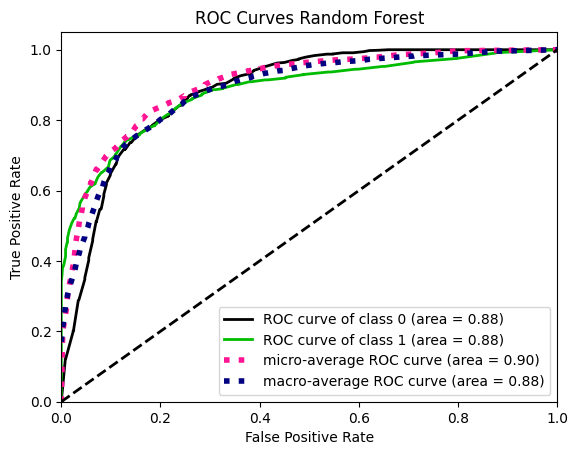

In [401]:
from scikitplot.metrics import plot_roc
import matplotlib.pyplot as plt

rf = MyRandomForest(n_estimators=50).fit(X_train, y_train.values.ravel())

y_true = y_valid
y_probas = rf.predict_proba(X_valid)
plot_roc(y_true, y_probas, title='ROC Curves Random Forest')
plt.show()

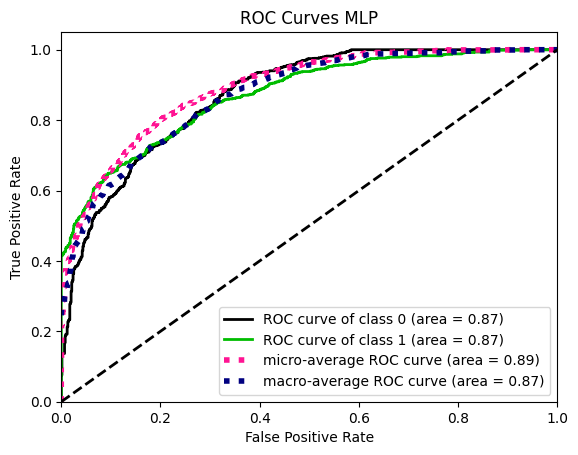

In [402]:
mlp = MyMLP(hidden_layer_sizes=(20,20,20), random_state=2, max_iter=500).fit(X_train, y_train.values.ravel())

y_true = y_valid
y_probas = mlp.predict_proba(X_valid)
plot_roc(y_true, y_probas, title='ROC Curves MLP')
plt.show()

In [366]:
print_scores(rf, X_valid, y_valid)

Accuracy:  0.8433005299015897
Precision:  0.8262518968133535
Recall:  0.7353139770425389


In [403]:
print("MLP: ", accuracy_score(y_test, mlp.predict(X_test)))
print("Random Forest: ", accuracy_score(y_test, rf.predict(X_test)))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').